<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/PR%C3%80CTICA_GUIADA/M%C3%A8tode_expl%C3%ADcit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aïllem $T_{i+1}^{(n)}$:

$T_{i+1}^{(n)}=Δt+\alpha T_{i}^{(n-1)}+βT_{i}^{(n)} + α T_{i}^{(n+1)} \ \ (1)$

On: $\ α=\frac{Δt}{\Delta x^2},\ β=1-\frac{2\Delta t}{\Delta x^2}$

In [ ]:
import numpy as np
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
import matplotlib.patches as pt

# CÀLCULS PREVIS
    # Dades de l'enunciat
C_v= 3686
rho= 1081
kappa= 0.56
sigma= 0.472
volts= 40
    # Amb aquests, calculem la difusivitat, que farem servir per a la normalització
alpha= kappa/(C_v*rho)

    # Imposem la nostra normalització
N= 101
x_0= 0.02 # Longitud de referència, triada per tal de normalitzar x_f,
x_f= 0.02/x_0 # Longitud final normalitzada

t_i= 0 #Temps inicial
t_0= x_0**2/alpha #Temps de referència, surt de la normalització de l'equació diferencial
t_f= 0.025 # Temps final ja normalitzat, ho diu l'enunciat

P_ext= volts**2*sigma/(2*(x_0)**2) # Calculada per anàlisi dimensional a partir de dades proporcionades, el factor 2 dividint és perquè s'ha d'agafar el voltatge efectiu
T_0= P_ext/(C_v*rho)*t_0 # Temperatura de referència, en kelvin
T_init= 309.65/T_0 # Temperatura inicial 36.5℃ normalitzada i en kelvins

    # Definim els tres casos a considerar de discretitzacions
dx= x_f/(N-1) # Valor de les particions espacials donat un nombre N de nodes espaials
dt_1= 0.51*dx**2
dt_2= 0.49*dx**2
dt_3= 0.25*dx**2

Bloc del càlcul amb Euler explícit:

In [ ]:
#Euler explícit

def Euler_explícit(T_i, t_f, dt, dx):
  T_i= np.array([T_i]*N)  #Vector columna de les T_i per cada n (punt de l'espai)
  alpha = dt / (dx**2)
  beta = 1 - 2 * alpha
  t_i= 0

  t = int(t_f/dt)
  for _ in range(t):
      T_iter= T_i.copy()  #Creem una còpia del vector temperatures per evitar
                          #actualitzar a mig procés el propi vector (cosa que portaria problemes)
      for i in range(1, len(T_i)-1):
        T_i[i]= (T_iter[i-1] + T_iter[i+1])*alpha + T_iter[i]*beta + dt #Eq 1 del text inicial

  return T_i*T_0 - 273.15

Plots:

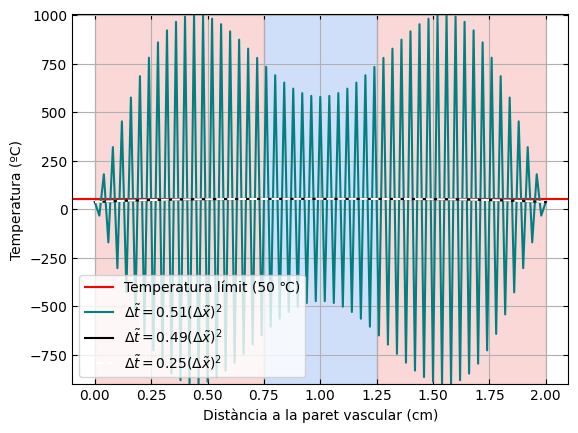

In [10]:
#Creació de la llista que farà d'eix de les x
dx_llista= np.linspace(0, 2, 101)

#Calculem per cada discretització i ho guardem a una variable
T1= Euler_explícit(T_init, t_f, dt_1, dx)
T2= Euler_explícit(T_init, t_f, dt_2, dx)
T3= Euler_explícit(T_init, t_f, 0.10*(dx)**2, dx)

fig, ax= plt.subplots()

lim_inf_y= float(np.floor(np.min(T1)))
altura= float(np.floor(np.max(T1)+1)-np.floor(np.min(T1)))

rectangle_cor= pt.Rectangle((0.75, lim_inf_y), 0.5, altura, color="cornflowerblue", alpha=0.3)
rectangle_esq= pt.Rectangle((0, lim_inf_y), 0.75, altura, color="lightcoral", alpha=0.3)
rectangle_dre= pt.Rectangle((1.25, lim_inf_y), 0.75, altura, color="lightcoral", alpha=0.3)

ax.add_patch(rectangle_cor)
ax.add_patch(rectangle_esq)
ax.add_patch(rectangle_dre)

plt.xlabel("Distància a la paret vascular (cm)")
plt.ylabel("Temperatura (ºC)")


plt.ylim(lim_inf_y, np.floor(np.max(T1)+1))
ax.axhline(y=50, color='red',label="Temperatura límit (50 ℃)")

plt.plot(dx_llista, T1, color="teal", label=r"$\Delta \tilde{t}= 0.51(\Delta \tilde{x})^2$")
plt.plot(dx_llista, T2, color="k", label=r"$\Delta \tilde{t}= 0.49(\Delta \tilde{x})^2$")
plt.plot(dx_llista, T3, color="white", label=r"$\Delta \tilde{t}= 0.25(\Delta \tilde{x})^2$", linestyle="--")
plt.legend()
plt.grid("equal")
plt.tick_params(direction="in", top=True, right=True)
plt.show()

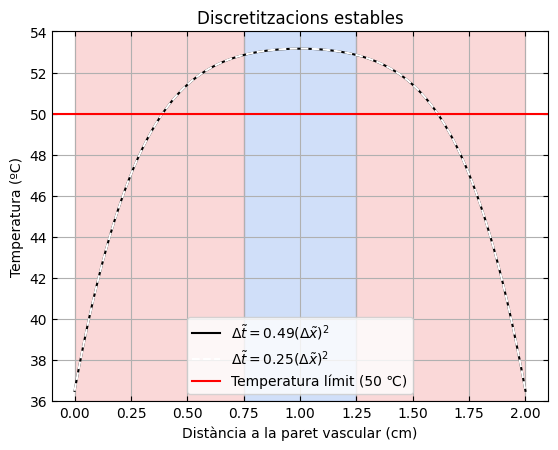

In [9]:
from matplotlib.lines import lineStyles
fig, ax= plt.subplots()

lim_inf_y= float(np.floor(np.min(T2)))
altura= float(np.floor(np.max(T2)+1)-np.floor(np.min(T2)))

rectangle_cor= pt.Rectangle((0.75, lim_inf_y), 0.5, altura, color="cornflowerblue", alpha=0.3)
rectangle_esq= pt.Rectangle((0, lim_inf_y), 0.75, altura, color="lightcoral", alpha=0.3)
rectangle_dre= pt.Rectangle((1.25, lim_inf_y), 0.75, altura, color="lightcoral", alpha=0.3)

ax.add_patch(rectangle_cor)
ax.add_patch(rectangle_esq)
ax.add_patch(rectangle_dre)

plt.title("Discretitzacions estables")
plt.xlabel("Distància a la paret vascular (cm)")
plt.ylabel("Temperatura (ºC)")

plt.ylim(lim_inf_y, np.floor(np.max(T2)+1))

plt.plot(dx_llista, T2, color="k", label=r"$\Delta \tilde{t}= 0.49(\Delta \tilde{x})^2$")
plt.plot(dx_llista, T3, color="white", label=r"$\Delta \tilde{t}= 0.25(\Delta \tilde{x})^2$", linestyle="--")
ax.axhline(y=50, color='red',label="Temperatura límit (50 ℃)")
plt.legend()
plt.grid("equal")
plt.tick_params(direction="in", top=True, right=True)
plt.show()

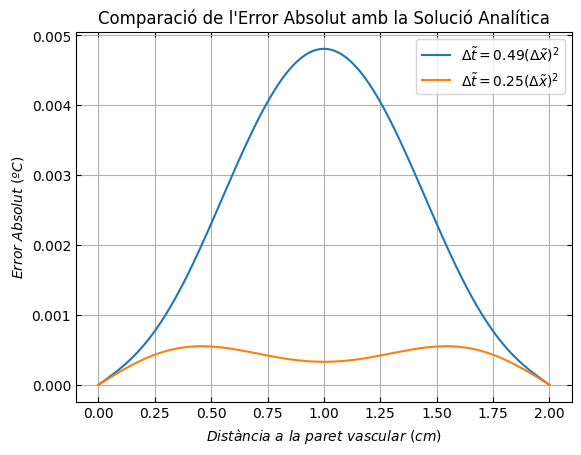

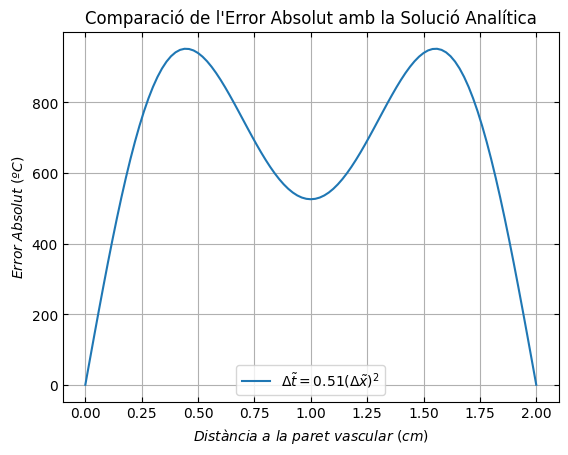

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#COMPARACIÓ AMB LA SOLUCIÓ ANALÍTICA

T_real_analitica = np.array([36.5, 37.66969108, 38.77435843, 39.81640155, 40.79821064, 41.72216161,
 42.59061136, 43.40589333, 44.17031304, 44.88614393, 45.55562325, 46.18094826,
 46.76427258, 47.30770281, 47.81329543, 48.28305392, 48.71892617, 49.12280218,
 49.49651205, 49.84182427, 50.16044422, 50.45401308, 50.72410691, 50.97223607,
 51.19984485, 51.40831139, 51.59894779, 51.77300053, 51.93165095, 52.07601607,
 52.20714947, 52.32604233, 52.43362469, 52.53076667, 52.61827989, 52.69691893,
 52.76738279, 52.83031642, 52.88631225, 52.93591169, 52.97960659, 53.01784069,
 53.05101097, 53.07946891, 53.10352169, 53.12343327, 53.13942529, 53.15167798,
 53.16033077, 53.16548287, 53.16719365, 53.16548287, 53.16033077, 53.15167798,
 53.13942529, 53.12343327, 53.10352169, 53.07946891, 53.05101097, 53.01784069,
 52.97960659, 52.93591169, 52.88631225, 52.83031642, 52.76738279, 52.69691893,
 52.61827989, 52.53076667, 52.43362469, 52.32604233, 52.20714947, 52.07601607,
 51.93165095, 51.77300053, 51.59894779, 51.40831139, 51.19984485, 50.97223607,
 50.72410691, 50.45401308, 50.16044422, 49.84182427, 49.49651205, 49.12280218,
 48.71892617, 48.28305392, 47.81329543, 47.30770281, 46.76427258, 46.18094826,
 45.55562325, 44.88614393, 44.17031304, 43.40589333, 42.59061136, 41.72216161,
 40.79821064, 39.81640155, 38.77435843, 37.66969108, 36.5])
 # Solució analítica en ºC prèviament calculada per el temps final

T1= np.squeeze(np.asarray(T1))  #Ho passem de matriu a array per poder restar-li la solució analítica
T2= np.squeeze(np.asarray(T2))
T3= np.squeeze(np.asarray(T3))

plt.figure()
plt.plot(dx_llista, np.abs(np.array(T2)-T_real_analitica), label=r"$\Delta\tilde{t}= 0.49(\Delta\tilde{x})^2$")
plt.plot(dx_llista, np.abs(np.array(T3)-T_real_analitica), label=r"$\Delta\tilde{t}= 0.25(\Delta\tilde{x})^2$")

plt.title("Comparació de l'Error Absolut amb la Solució Analítica")
plt.xlabel(r"$Distància\ a\ la\ paret\ vascular\ (cm)$")
plt.ylabel(r"$Error\ Absolut\ (ºC)$")
plt.legend()
plt.tick_params(direction="in", top=True, right=True)
plt.grid(True)
plt.show()

plt.figure()
plt.plot(dx_llista, np.abs(np.array(T1)-T_real_analitica), label=r"$\Delta\tilde{t}= 0.51(\Delta\tilde{x})^2$")
plt.title("Comparació de l'Error Absolut amb la Solució Analítica")
plt.xlabel(r"$Distància\ a\ la\ paret\ vascular\ (cm)$")
plt.ylabel(r"$Error\ Absolut\ (ºC)$")
plt.legend()
plt.tick_params(direction="in", top=True, right=True)
plt.grid(True)
plt.show()